In [113]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import RandomNormal
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import mtcnn
from tqdm.notebook import tqdm

plt.ioff()  # not to show images inline
os.makedirs("out4", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


Download data from https://www.kaggle.com/jessicali9530/celeba-dataset/data then extract locate at "./data/" folder".  Expected structure is:

```bash
data/
   img_align_celeba/
     img_align_celeba/
       000001.jpg
       000002.jpg
       ...
```       


In [15]:
def check_celeba_data(datadir="./data"):
    imgdir = os.path.join(datadir, "img_align_celeba/img_align_celeba")
    if not os.path.isdir(imgdir):
        print("%s does not exist" % imgdir)
        return
    images = os.listdir(imgdir)
    exts = {}
    for i in images:
        ext = i[-4:]
        exts[ext] = 1 + exts.get(ext, 0)
    print("found %d image files:" % len(images),
          images[0:5], "...")
    print("extentions:", exts)
check_celeba_data()

found 202599 image files: ['168575.jpg', '146048.jpg', '177261.jpg', '077897.jpg', '122224.jpg'] ...
extentions: {'.jpg': 202599}


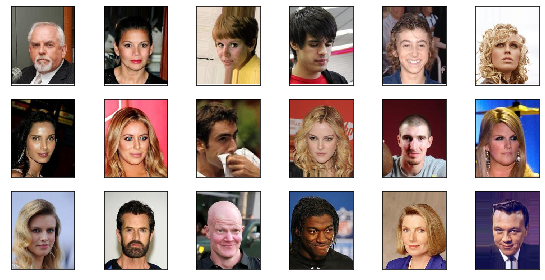

images shapes and value range:
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 248 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8
(218, 178, 3) 0 255 uint8


In [61]:
def plot_images(images, nrow=3, ncol=6, figsize=(8, 4)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i, j in itertools.product(range(nrow), range(ncol)):
        k = i*ncol + j
        if k < len(images):
            ax[i][j].imshow(images[k])
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    fig.tight_layout()
    plt.close(fig)
    return fig

def load_sample_images(directory, size=18):
    images = os.listdir(directory)
    images = np.random.choice(images, size=size, replace=False)
    images = [os.path.join(directory, i) for i in images]
    images = [Image.open(i).convert("RGB") for i in images]
    return images

images = load_sample_images("data/img_align_celeba/img_align_celeba/", size=3*6)
display(plot_images(images, nrow=3, ncol=6))
print("images shapes and value range:")
for i in images:
    x = np.array(i)
    print(x.shape, np.min(x), np.max(x), x.dtype)

detected faces:


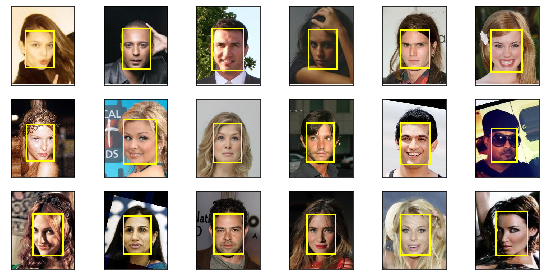

In [74]:
_detector = mtcnn.MTCNN()
def add_detected_face(image):
    image = image.copy()
    x = np.array(image)
    res = _detector.detect_faces(x)
    if len(res) < 1:
        print("No face detected")
        return image
    x1,y1,w,h = res[0]["box"]
    draw = ImageDraw.Draw(image)
    draw.rectangle(((x1,y1), (x1+w,y1+h)), outline="yellow", width=4)
    return image

images = load_sample_images("data/img_align_celeba/img_align_celeba/", size=3*6)
images_with_rect = [add_detected_face(i) for i in images]     
print("detected faces:")
display(plot_images(images_with_rect, nrow=3, ncol=6))

In [82]:
def crop_face(image, margin=0.0):
    x = np.array(image)
    res = _detector.detect_faces(x)
    if len(res) < 1:
        return None
    x1,y1,w,h = res[0]["box"]
    x1, x2 = max(0, round(x1 - margin*w)), min(x.shape[1], round(x1 + w + margin*w))
    y1, y2 = max(0, round(y1 - margin*h)), min(x.shape[0], round(y1 + h + margin*h))
    x = x[y1:y2, x1:x2]
    return Image.fromarray(x)

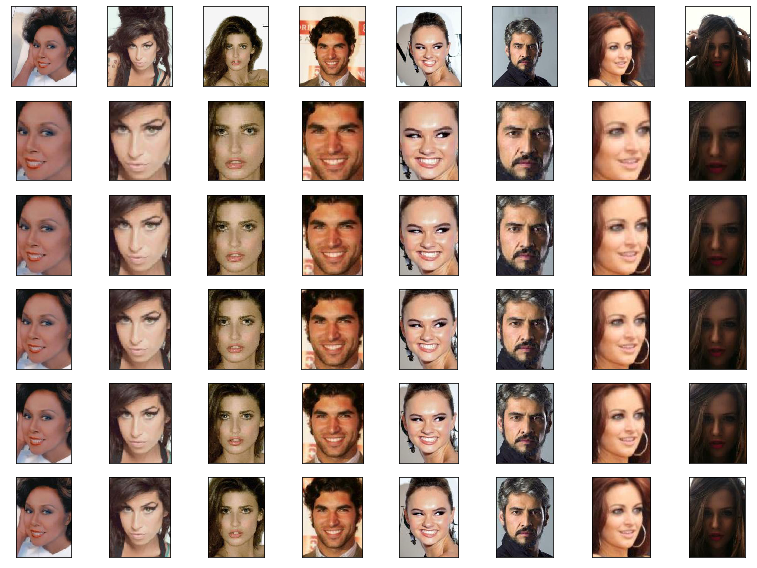

In [93]:
images = load_sample_images("data/img_align_celeba/img_align_celeba/", size=8)
images2 = []
for margin in [None, 0.0, 0.05, 0.1, 0.15, 0.2]:
    for i in images:
        if margin is None:
            images2.append(i)
        else:
            images2.append(crop_face(i, margin))
display(plot_images(images2, nrow=6, ncol=8, figsize=(11, 8)))

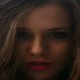

In [102]:
class ImagePrep:
    def __init__(self, margin=0.05, shape=(80, 80)):
        self.margin = margin
        self.shape = shape
    
    def __call__(self, image):
        image = crop_face(image, margin=self.margin)
        if image is None:
            return None
        image = image.resize(self.shape)
        return image
        
image_prep = ImagePrep()
display(image_prep(i))

In [155]:
def make_preped_images(imagedir, savename, replace=False, debug=False):
    if os.path.isfile(savename) and not replace:
        obj = np.load(savename)
        x, y = obj["preped"], obj["error"]
        return x, y
    image_prep = ImagePrep()
    files = os.listdir(imagedir)
    n = len(files)
    x = np.zeros((n, 80, 80, 3), dtype="uint8")
    # pre-allocate and index update
    y = np.zeros((0, 218, 178, 3), dtype="uint8")
    # pre-allocation caused memory error. so we use vstack for updates
    i_x = 0
    for f in tqdm(files):
        if debug and i_x >= 500:
            break
        img = Image.open(os.path.join(imagedir, f))
        img2 = image_prep(img)
        if img2 is None:
            print("face detection error for", f)
            y = np.vstack((y, np.expand_dims(img, axis=0)))
            continue
        #tmp = np.expand_dims(np.array(img2), axis=0)
        #x = np.vstack((x, tmp))
        x[i_x] = img2
        i_x += 1
    x = x[0:i_x]  # remove indices not used
    np.savez_compressed(savename, preped=x, error=y)
    return x, y

x, y = make_preped_images("./data/img_align_celeba/img_align_celeba/",
                          "out4/celeba_preped.npz",
                          replace=True,
                          debug=False)
print(x.shape)
print(y.shape)

face detection error for 121050.jpg
face detection error for 059743.jpg
face detection error for 124757.jpg
face detection error for 119889.jpg
face detection error for 077942.jpg
face detection error for 003946.jpg
face detection error for 125880.jpg
face detection error for 041222.jpg
face detection error for 131065.jpg
face detection error for 153323.jpg
face detection error for 179577.jpg
face detection error for 103503.jpg
face detection error for 157304.jpg
face detection error for 072252.jpg
face detection error for 084472.jpg
face detection error for 050841.jpg
face detection error for 073845.jpg
face detection error for 142324.jpg
face detection error for 048459.jpg
face detection error for 076286.jpg
face detection error for 098131.jpg
face detection error for 155885.jpg
face detection error for 031125.jpg
face detection error for 067318.jpg
face detection error for 052507.jpg
face detection error for 183917.jpg
face detection error for 154918.jpg
face detection error for 092

face detection error for 050199.jpg
face detection error for 086044.jpg
face detection error for 024184.jpg
face detection error for 080480.jpg
face detection error for 165868.jpg
face detection error for 136982.jpg
face detection error for 087318.jpg
face detection error for 101787.jpg
face detection error for 122167.jpg
face detection error for 095581.jpg
face detection error for 195995.jpg
face detection error for 122022.jpg
face detection error for 049550.jpg
face detection error for 166922.jpg
face detection error for 184887.jpg
face detection error for 094848.jpg
face detection error for 093027.jpg
face detection error for 037162.jpg
face detection error for 066891.jpg
face detection error for 025316.jpg
face detection error for 140217.jpg
face detection error for 044200.jpg
face detection error for 128064.jpg
face detection error for 032821.jpg
face detection error for 076483.jpg
face detection error for 007726.jpg
face detection error for 082103.jpg
face detection error for 053

examples of images successfully preped


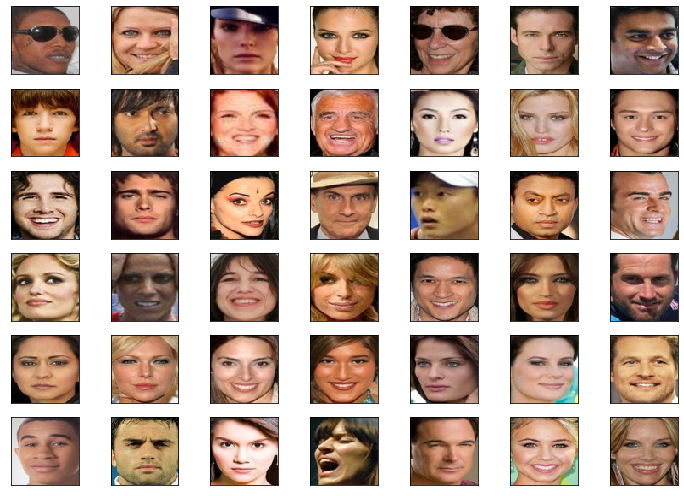

In [169]:
print("examples of images successfully preped")
i = np.random.choice(len(x), 42)
plot_images(x[i], nrow=6, ncol=7, figsize=(10, 7))

examples of images with face detection error


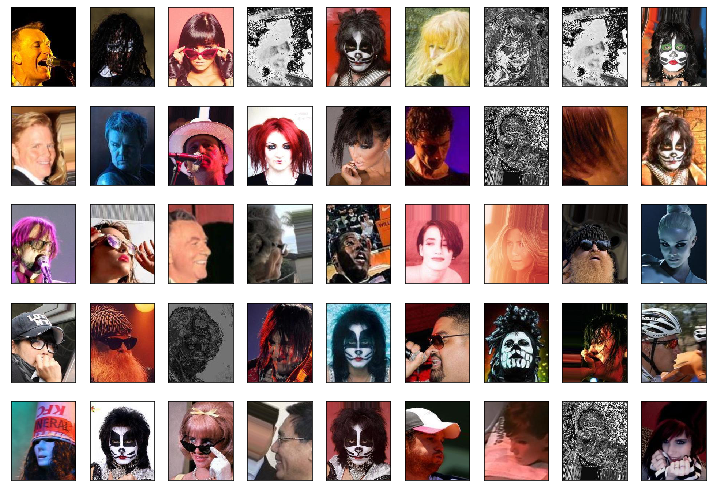

In [172]:
print("examples of images with face detection error")
i = np.random.choice(len(y), 45)
plot_images(y[i], nrow=5, ncol=9, figsize=(10, 7))